In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pymorphy2
!pip install spacy
!python -m spacy download ru_core_news_sm
!pip install bertopic

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 80.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=2d9166448669e92c4f605b1088237ed350e9a2bee72f20954405c0be419878d9
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 106.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by sel

In [ ]:
import spacy
import re
import pymorphy2
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer
import spacy

from transformers import BertModel, BertTokenizer
import torch

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances, manhattan_distances
from bertopic import BERTopic
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
data = '/content/drive/MyDrive/Colab Notebooks/Crime And Punishment.txt'

with open(data, 'r', encoding='utf-8') as file:
    text = file.read()

print(text[:1000])

Annotation


«Преступление и наказание» – гениальный роман, главные темы которого: преступление и наказание, жертвенность и любовь, свобода и гордость человека – обрамлены почти детективным сюжетом.

Многократно экранизированный и не раз поставленный на сцене, он и по сей день читается на одном дыхании.





* * *



Часть перваяI

II

III

IV

V

VI

VII





Часть втораяI

II

III

IV

V

VI

VII





Часть третьяI

II

III

IV

V

VI





Часть четвертаяI

II

III

IV

V

VI





Часть пятаяI

II

III

IV

V





Часть шестаяI

II

III

IV

V

VI

VII

VIII





ЭпилогI

II





notes1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95





* * *





Часть первая




I



Предобработка текста

In [ ]:
nltk.download('punkt')
nlp = spacy.load('ru_core_news_sm')
morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
  # удаление заголовков и номеров частей
    text = re.sub(r'\bЧасть\s+\S+\s*\n', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bЭпилог\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bэпилогi\b', '', text, flags=re.IGNORECASE)  # удаление "эпилогi"
    text = re.sub(r'\bnotes\d+', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\bAnnotation\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\b[ivxlcdm]+\b', '', text, flags=re.IGNORECASE)  # удаление римских чисел
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = nlp.Defaults.stop_words
    tokens = [token for token in tokens if token not in stop_words]
    lemmatized_tokens = [morph.parse(token)[0].normal_form for token in tokens]
    return ' '.join(lemmatized_tokens)

# разделение текста на предложения
sentences = sent_tokenize(text)

processed_sentences = [preprocess_text(sentence) for sentence in sentences]

# удаление пустых предложений после предобработки
processed_sentences = [sentence for sentence in processed_sentences if sentence.strip()]

print(f"Количество предложений: {len(processed_sentences)}")
print("Первые пять очищенных предложений:")
for i, sentence in enumerate(processed_sentences[:5]):
    print(f"{i+1}. {sentence}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Количество предложений: 12582
Первые пять очищенных предложений:
1. преступление наказание гениальный роман главный тема преступление наказание жертвенность любовь свобода гордость человек обрамить детективный сюжет
2. многократно экранизировать раз поставить сцена день читаться дыхание
3. июль чрезвычайно жаркое время вечер молодой человек выйти каморка нанимать жилец переулок улица медленно нерешимость отправиться мост
4. благополучно избегнуть встреча хозяйка лестница
5. каморка приходиться самый кровля высокий пятиэтажный дом походить шкаф квартира


Информация о датасете находится в файле Задание 3.2

### SentenceTransformer

In [ ]:
"""# загрузка BERT
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_embeddings(sentences):
    embeddings = []
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy())
    return np.array(embeddings)

embeddings = get_embeddings(processed_sentences)"""


from sentence_transformers import SentenceTransformer

model_t = SentenceTransformer('all-mpnet-base-v2')
embeddings =model_t.encode(processed_sentences)
print(embeddings.shape)

(12582, 768)


### K-means кластеризация с евклидовым, косинусным и манхэттенским расстоянием

In [ ]:
kmeans_euclidean = KMeans(n_clusters=5, random_state=0)
labels_kmeans_euclidean = kmeans_euclidean.fit_predict(embeddings)
score_kmeans_euclidean = silhouette_score(embeddings, labels_kmeans_euclidean, metric='euclidean')
print(f'Silhouette Score for K-means with Euclidean distance: {score_kmeans_euclidean}')

embeddings_normalized = normalize(embeddings)
kmeans_cosine = KMeans(n_clusters=5, random_state=0)
labels_kmeans_cosine = kmeans_cosine.fit_predict(embeddings_normalized)
score_kmeans_cosine = silhouette_score(embeddings_normalized, labels_kmeans_cosine, metric='cosine')
print(f'Silhouette Score for K-means with Cosine distance: {score_kmeans_cosine}')

kmeans_manhattan = KMeans(n_clusters=5, random_state=0)
labels_kmeans_manhattan = kmeans_manhattan.fit_predict(embeddings)
score_kmeans_manhattan = silhouette_score(embeddings, labels_kmeans_manhattan, metric='manhattan')
print(f'Silhouette Score for K-means with Manhattan distance: {score_kmeans_manhattan}')

Silhouette Score for K-means with Euclidean distance: 0.05598609894514084
Silhouette Score for K-means with Cosine distance: 0.10353797674179077
Silhouette Score for K-means with Manhattan distance: 0.053895909728840945


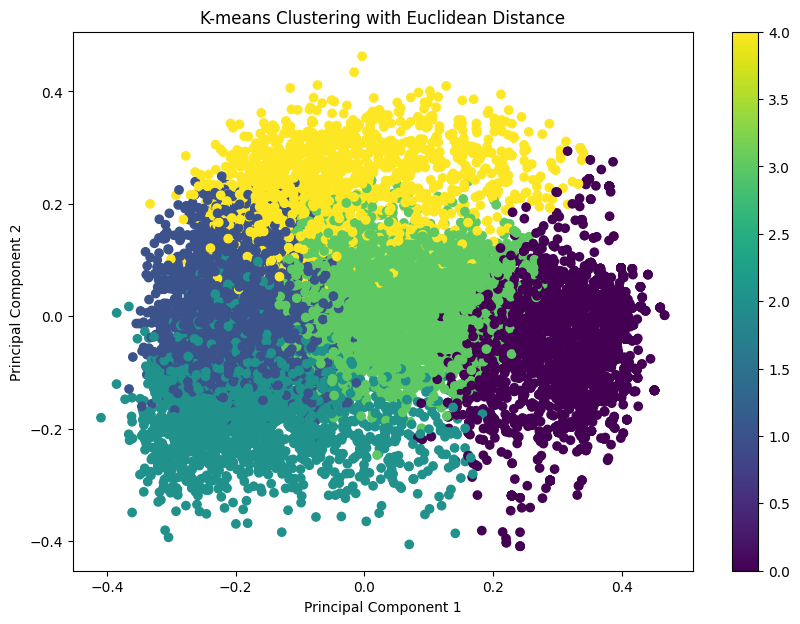

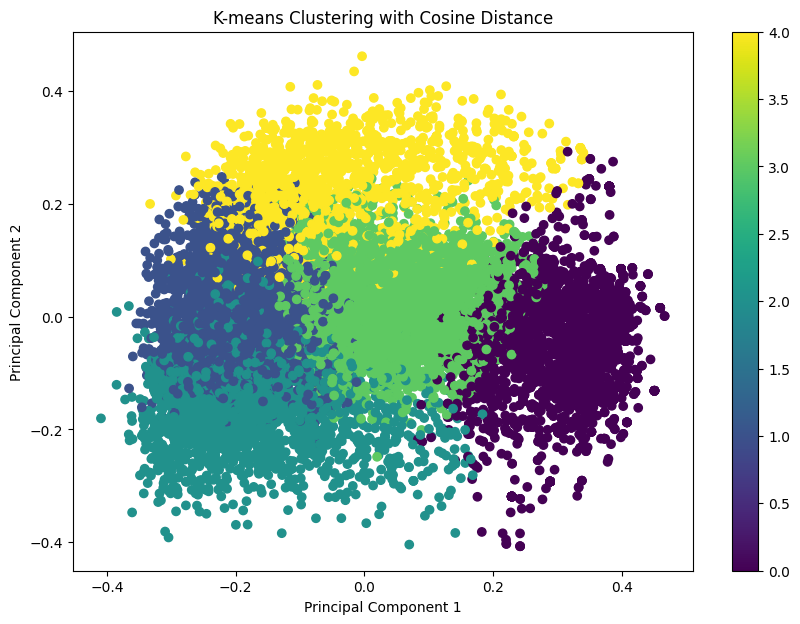

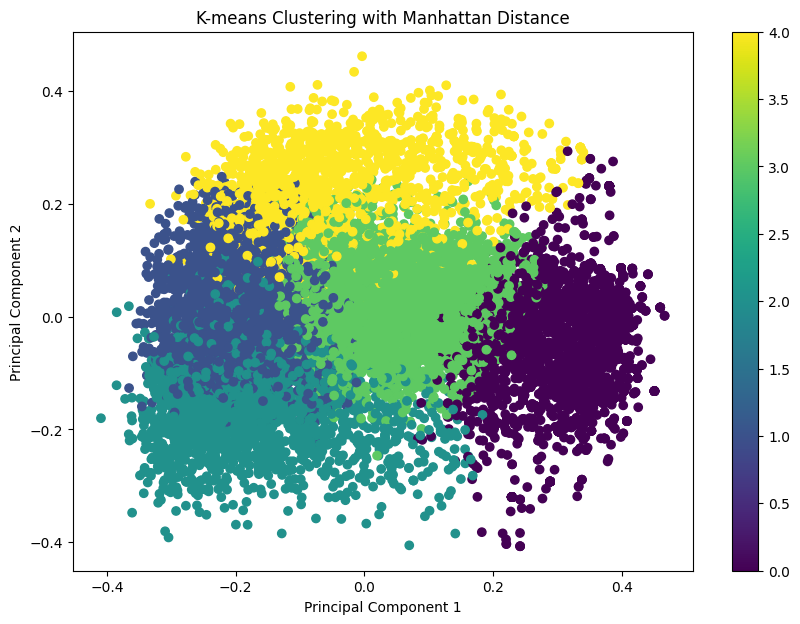

In [ ]:
# кластеры K-means
def visualize_clusters(matrix, labels, title):
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(matrix)
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

visualize_clusters(embeddings, labels_kmeans_euclidean, 'K-means Clustering with Euclidean Distance')
visualize_clusters(embeddings_normalized, labels_kmeans_cosine, 'K-means Clustering with Cosine Distance')
visualize_clusters(embeddings, labels_kmeans_manhattan, 'K-means Clustering with Manhattan Distance')

### DBSCAN кластеризация с евклидовым, косинусным и манхэттенским расстоянием

In [ ]:
dbscan_euclidean = DBSCAN(metric='euclidean', eps=0.5, min_samples=5)
labels_dbscan_euclidean = dbscan_euclidean.fit_predict(embeddings)
if len(set(labels_dbscan_euclidean)) > 1:
    score_dbscan_euclidean = silhouette_score(embeddings, labels_dbscan_euclidean, metric='euclidean')
    print(f'Silhouette Score for DBSCAN with Euclidean distance: {score_dbscan_euclidean}')
else:
    print("DBSCAN with Euclidean distance did not find multiple clusters.")

dbscan_cosine = DBSCAN(metric='cosine', eps=0.5, min_samples=5)
labels_dbscan_cosine = dbscan_cosine.fit_predict(embeddings_normalized)
if len(set(labels_dbscan_cosine)) > 1:
    score_dbscan_cosine = silhouette_score(embeddings_normalized, labels_dbscan_cosine, metric='cosine')
    print(f'Silhouette Score for DBSCAN with Cosine distance: {score_dbscan_cosine}')
else:
    print("DBSCAN with Cosine distance did not find multiple clusters.")

dbscan_manhattan = DBSCAN(metric='manhattan', eps=0.5, min_samples=5)
labels_dbscan_manhattan = dbscan_manhattan.fit_predict(embeddings)
if len(set(labels_dbscan_manhattan)) > 1:
    score_dbscan_manhattan = silhouette_score(embeddings, labels_dbscan_manhattan, metric='manhattan')
    print(f'Silhouette Score for DBSCAN with Manhattan distance: {score_dbscan_manhattan}')
else:
    print("DBSCAN with Manhattan distance did not find multiple clusters.")

Silhouette Score for DBSCAN with Euclidean distance: -0.15070191025733948
Silhouette Score for DBSCAN with Cosine distance: 0.5596039891242981
Silhouette Score for DBSCAN with Manhattan distance: -0.12949730073284427


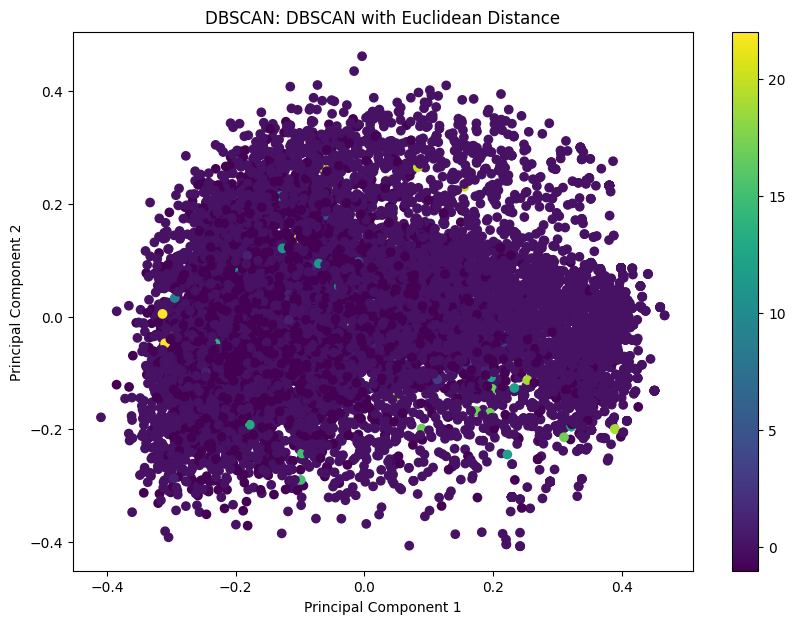

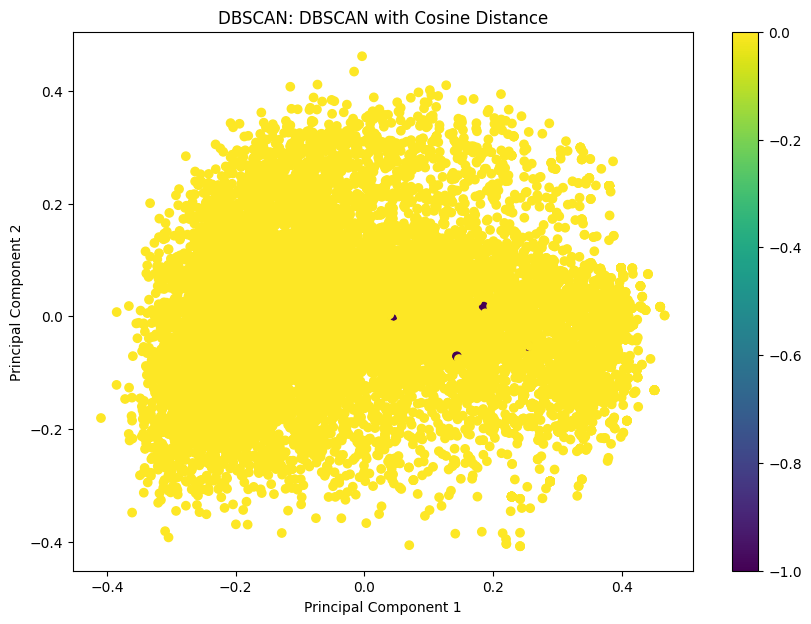

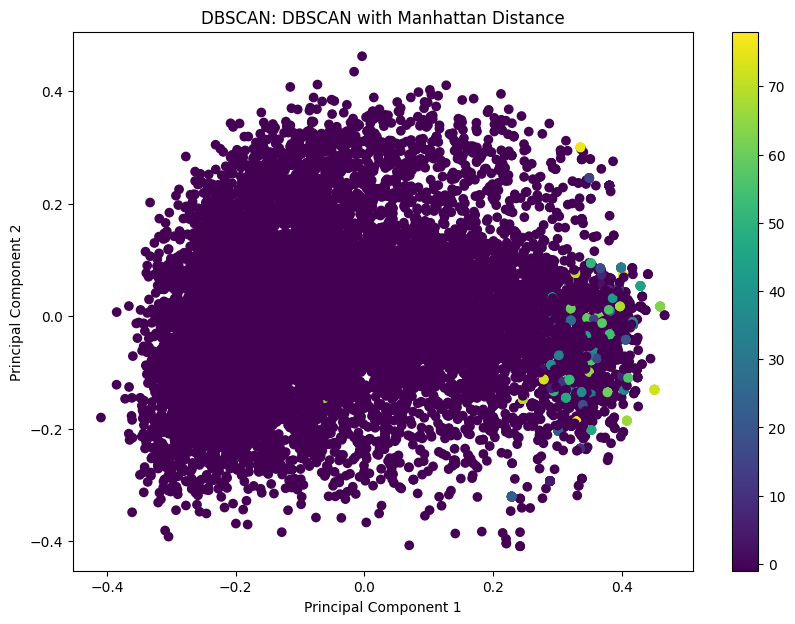

In [ ]:
# кластеры DBSCAN
def visualize_dbscan_clusters(matrix, labels, title):
    pca = PCA(n_components=2)
    reduced_matrix = pca.fit_transform(matrix)
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=labels, cmap='viridis')
    plt.title(f'DBSCAN: {title}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar()
    plt.show()

# результаты DBSCAN
visualize_dbscan_clusters(embeddings, labels_dbscan_euclidean, 'DBSCAN with Euclidean Distance')
visualize_dbscan_clusters(embeddings_normalized, labels_dbscan_cosine, 'DBSCAN with Cosine Distance')
visualize_dbscan_clusters(embeddings, labels_dbscan_manhattan, 'DBSCAN with Manhattan Distance')

### BERTopic

In [ ]:
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(processed_sentences, embeddings)

topic_info = topic_model.get_topic_info()
print(topic_info)

topic_model.visualize_topics()

     Topic  Count     Name        Representation  \
0       -1   4813   -1____  [, , , , , , , , , ]   
1        0    612    0____  [, , , , , , , , , ]   
2        1    338    1____  [, , , , , , , , , ]   
3        2    259    2____  [, , , , , , , , , ]   
4        3    252    3____  [, , , , , , , , , ]   
..     ...    ...      ...                   ...   
176    175     11  175____  [, , , , , , , , , ]   
177    176     11  176____  [, , , , , , , , , ]   
178    177     10  177____  [, , , , , , , , , ]   
179    178     10  178____  [, , , , , , , , , ]   
180    179     10  179____  [, , , , , , , , , ]   

                                   Representative_Docs  
0    [соня сообщать помещение острог общий внутренн...  
1    [кругом толпа смеяться смеяться этака лядащий ...  
2    [приказать заложить лошадь обед ехать город сл...  
3    [брат славный парень увидеть, добреть барин, б...  
4    [хороший спать решиться, решить перед совестно...  
..                               